In [42]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
import precision_recall_cutoff


# Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'gabriel-predictive-analytics'
bucket = s3.Bucket(bucket_name)

# Defining the file to be read from s3 bucket
file_key_train = "train.csv"
bucket_object = bucket.Object(file_key_train)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# Reading the csv file
train = pd.read_csv(file_content_stream, sep="|")

# Defining the file to be read from s3 bucket
file_key_test = "test.csv"
bucket_object_test = bucket.Object(file_key_test)
file_object_test = bucket_object_test.get()
file_content_stream_test = file_object_test.get('Body')

# Reading the csv file
test = pd.read_csv(file_content_stream_test, sep='|')

In [43]:
test.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526


[Text(804.8076923076923, 951.3000000000001, 'trustLevel <= 1.5\ngini = 0.104\nsamples = 1503\nvalue = [1420, 83]'),
 Text(429.2307692307692, 679.5, 'lineItemVoidsPerPosition <= 0.528\ngini = 0.388\nsamples = 262\nvalue = [193, 69]'),
 Text(214.6153846153846, 407.70000000000005, 'scannedLineItemsPerSecond <= 0.012\ngini = 0.476\nsamples = 174\nvalue = [106, 68]'),
 Text(107.3076923076923, 135.89999999999998, 'gini = 0.0\nsamples = 27\nvalue = [27, 0]'),
 Text(321.9230769230769, 135.89999999999998, 'gini = 0.497\nsamples = 147\nvalue = [79, 68]'),
 Text(643.8461538461538, 407.70000000000005, 'lineItemVoids <= 10.5\ngini = 0.022\nsamples = 88\nvalue = [87, 1]'),
 Text(536.5384615384615, 135.89999999999998, 'gini = 0.0\nsamples = 81\nvalue = [81, 0]'),
 Text(751.1538461538462, 135.89999999999998, 'gini = 0.245\nsamples = 7\nvalue = [6, 1]'),
 Text(1180.3846153846155, 679.5, 'trustLevel <= 2.5\ngini = 0.022\nsamples = 1241\nvalue = [1227, 14]'),
 Text(1073.076923076923, 407.70000000000005, 

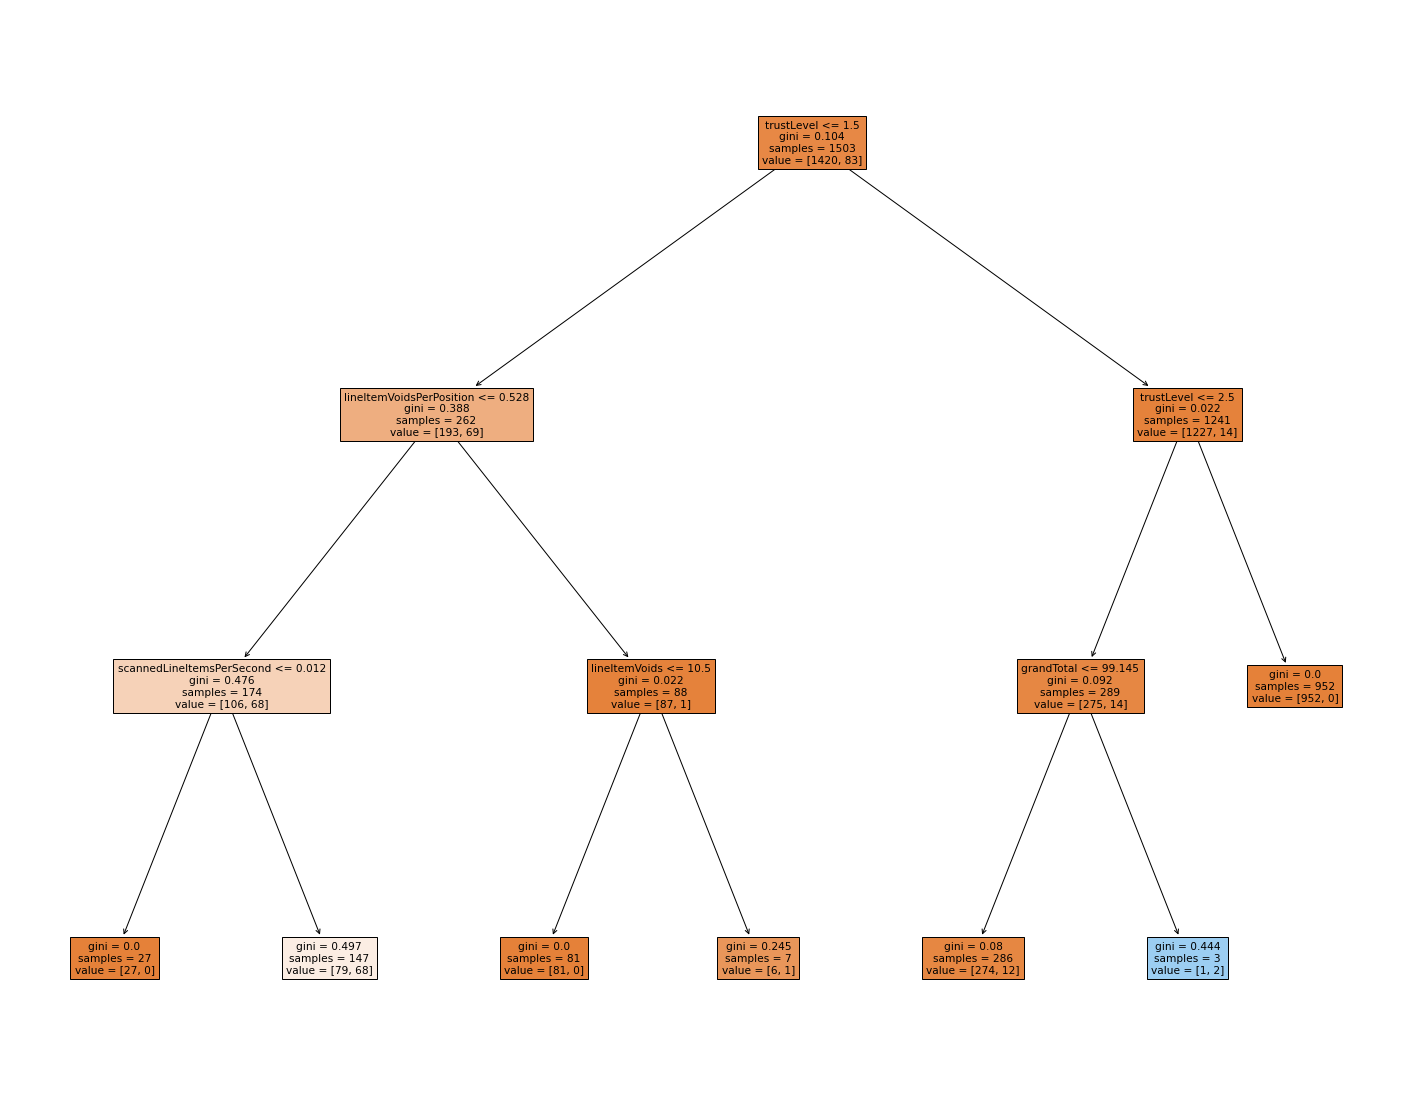

In [44]:
## Selecting input and target variables
X = train[["trustLevel", "totalScanTimeInSeconds", "grandTotal", "lineItemVoids",  "scannedLineItemsPerSecond", 'valuePerSecond', "lineItemVoidsPerPosition"]]
Y = train['fraud']

# Spliting the train dataset into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

# Building the decision tree on train data-frame
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

# Visualizing the decision-tree model
fig = plt.figure(figsize = (25,20))
plot_tree(tree_md, feature_names = X.columns, filled = True)

In [ ]:
"""
To the Left = Yes
To the Right = No

value = [0: No fraud , 1: fraud]
"""

In [45]:
## Creating interactions/features from the decision tree
# interaction 1
train['interaction_1'] = np.where((train['trustLevel'] <= 1.5) & 
                                     (train['scannedLineItemsPerSecond'] > 0.012), 1, 0)

# interaction 2
train['interaction_2'] = np.where((train['trustLevel'] <= 1.5) & 
                                     (train['scannedLineItemsPerSecond'] <= 0.012), 1, 0)

# interaction 3
train['interaction_3'] = np.where((train['trustLevel'] > 1.5) & 
                                     (train['trustLevel'] <= 2.5), 1, 0)

# interaction 4
train['interaction_4'] = np.where((train['trustLevel'] > 2.5), 1, 0)
                                  
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,interaction_1,interaction_2,interaction_3,interaction_4
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0,0,0,0,1
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0,0,0,0,1
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0,0,0,0,1
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0,0,0,0,1
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0,0,0,0,1


In [46]:
train['average_seconds_per_item'] = round(train['totalScanTimeInSeconds'] / train['grandTotal'], 2)
train

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,interaction_1,interaction_2,interaction_3,interaction_4,average_seconds_per_item
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0,0,0,0,1,19.27
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0,0,0,0,1,3.95
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0,0,0,0,1,24.39
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0,0,0,0,1,19.40
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0,0,0,0,1,5.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874,1,321,76.03,8,7,2,0.071651,0.236854,0.347826,0,1,0,0,0,4.22
1875,1,397,41.89,5,5,0,0.065491,0.105516,0.192308,1,1,0,0,0,9.48
1876,4,316,41.83,5,8,1,0.094937,0.132373,0.166667,0,0,0,0,1,7.55
1877,2,685,62.68,1,6,2,0.035036,0.091504,0.041667,0,0,0,1,0,10.93


In [47]:
## Changing sales to dummy variables
train = pd.concat([train, pd.get_dummies(train['trustLevel'], prefix= 'trustLevel')], axis = 1)


train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,interaction_1,interaction_2,interaction_3,interaction_4,average_seconds_per_item,trustLevel_1,trustLevel_2,trustLevel_3,trustLevel_4,trustLevel_5,trustLevel_6
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0,0,0,0,1,19.27,0,0,0,0,1,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0,0,0,0,1,3.95,0,0,1,0,0,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0,0,0,0,1,24.39,0,0,1,0,0,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0,0,0,0,1,19.40,0,0,0,0,0,1
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0,0,0,0,1,5.27,0,0,0,0,1,0


In [48]:
train.columns

Index(['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids',
       'scansWithoutRegistration', 'quantityModifications',
       'scannedLineItemsPerSecond', 'valuePerSecond',
       'lineItemVoidsPerPosition', 'fraud', 'interaction_1', 'interaction_2',
       'interaction_3', 'interaction_4', 'average_seconds_per_item',
       'trustLevel_1', 'trustLevel_2', 'trustLevel_3', 'trustLevel_4',
       'trustLevel_5', 'trustLevel_6'],
      dtype='object')

In [49]:
## Standardizing variables

In [50]:
# Defining sacaler
scaler = MinMaxScaler()

# Changing number_project and average_monthly_company to 0-1 scale
train[['totalScanTimeInSeconds_0_1', 'grandTotal_0_1', 'lineItemVoids_0_1', 'scansWithoutRegistration_0_1', 
       'quantityModifications_0_1', 'scannedLineItemsPerSecond_0_1', 'valuePerSecond_0_1', 'lineItemVoidsPerPosition_0_1', 'average_seconds_per_item_01']] = scaler.fit_transform(
    train[['totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids', 'scansWithoutRegistration', 
       'quantityModifications', 'scannedLineItemsPerSecond', 'valuePerSecond', 'lineItemVoidsPerPosition', 'average_seconds_per_item']])

train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,interaction_1,interaction_2,interaction_3,interaction_4,average_seconds_per_item,trustLevel_1,trustLevel_2,trustLevel_3,trustLevel_4,trustLevel_5,trustLevel_6,totalScanTimeInSeconds_0_1,grandTotal_0_1,lineItemVoids_0_1,scansWithoutRegistration_0_1,quantityModifications_0_1,scannedLineItemsPerSecond_0_1,valuePerSecond_0_1,lineItemVoidsPerPosition_0_1,average_seconds_per_item_01
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0,0,0,0,1,19.27,0,0,0,0,1,0,0.575178,0.547174,0.636364,0.0,0.6,0.004045,0.001370,0.021944,0.000131
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0,0,0,0,1,3.95,0,0,1,0,0,0,0.057955,0.273637,0.454545,0.2,0.8,0.019364,0.006689,0.032468,0.000027
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0,0,0,0,1,24.39,0,0,1,0,0,0,0.827775,0.621811,0.272727,1.0,1.0,0.001204,0.001083,0.020979,0.000165
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0,0,0,0,1,19.40,0,0,0,0,0,1,0.978130,0.923462,0.727273,0.4,0.8,0.002347,0.001361,0.025078,0.000132
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0,0,0,0,1,5.27,0,0,0,0,1,0,0.234008,0.815608,0.272727,0.7,0.4,0.009337,0.005007,0.010101,0.000036


In [51]:
train.columns

Index(['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids',
       'scansWithoutRegistration', 'quantityModifications',
       'scannedLineItemsPerSecond', 'valuePerSecond',
       'lineItemVoidsPerPosition', 'fraud', 'interaction_1', 'interaction_2',
       'interaction_3', 'interaction_4', 'average_seconds_per_item',
       'trustLevel_1', 'trustLevel_2', 'trustLevel_3', 'trustLevel_4',
       'trustLevel_5', 'trustLevel_6', 'totalScanTimeInSeconds_0_1',
       'grandTotal_0_1', 'lineItemVoids_0_1', 'scansWithoutRegistration_0_1',
       'quantityModifications_0_1', 'scannedLineItemsPerSecond_0_1',
       'valuePerSecond_0_1', 'lineItemVoidsPerPosition_0_1',
       'average_seconds_per_item_01'],
      dtype='object')

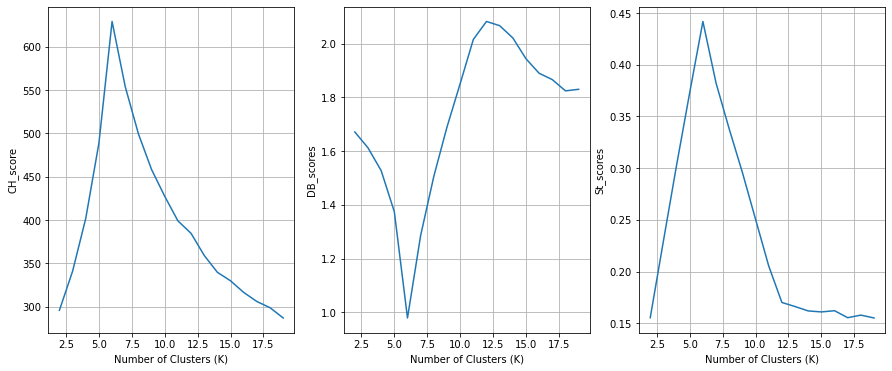

In [52]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

X = train[['totalScanTimeInSeconds_0_1', 'grandTotal_0_1', 'lineItemVoids_0_1', 'scansWithoutRegistration_0_1', 
       'quantityModifications_0_1', 'scannedLineItemsPerSecond_0_1', 'valuePerSecond_0_1', 'lineItemVoidsPerPosition_0_1',
         'average_seconds_per_item_01',  'trustLevel_1', 'trustLevel_2', 'trustLevel_3', 'trustLevel_4', 'trustLevel_5', 'trustLevel_6']]

# Defining the number of clusters to be considered
krange = list(range(2, 20))

# Defining list to store scores
CH_scores, DB_scores, St_scores = list(), list(), list()

for clusters in krange:
    
    # Defining the k-means model
    cluster_md = KMeans(n_clusters = clusters, n_init = 20).fit(X)
    cluster_assignments = cluster_md.labels_
    
    # Extracting the CH, DB, and St scores
    CH = calinski_harabasz_score(X, cluster_assignments)
    DB = davies_bouldin_score(X, cluster_assignments)
    St = silhouette_score(X, cluster_assignments)
    
    # Appending scores
    CH_scores.append(CH)
    DB_scores.append(DB)
    St_scores.append(St)
    
# Visualizing the scores
## calinski_harabasz_score
fig, axs = plt.subplots(1, 3, figsize = (15, 6))
axs[0].plot(krange, CH_scores)
axs[0].set_xlabel('Number of Clusters (K)')
axs[0].set_ylabel('CH_score')
axs[0].grid()

## davies_bouldin_score
axs[1].plot(krange, DB_scores)
axs[1].set_xlabel('Number of Clusters (K)')
axs[1].set_ylabel('DB_scores')
axs[1].grid()

## silhouette_score
axs[2].plot(krange, St_scores)
axs[2].set_xlabel('Number of Clusters (K)')
axs[2].set_ylabel('St_scores')
axs[2].grid()


### From the visualization, six clusters seems to be the appropriate number of clusters for the data.

### Labeling observations with KMeans model

In [53]:
cluster_md = KMeans(n_clusters = 6, n_init = 20).fit(X)
train['Labels'] = cluster_md.labels_
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,interaction_1,interaction_2,interaction_3,interaction_4,average_seconds_per_item,trustLevel_1,trustLevel_2,trustLevel_3,trustLevel_4,trustLevel_5,trustLevel_6,totalScanTimeInSeconds_0_1,grandTotal_0_1,lineItemVoids_0_1,scansWithoutRegistration_0_1,quantityModifications_0_1,scannedLineItemsPerSecond_0_1,valuePerSecond_0_1,lineItemVoidsPerPosition_0_1,average_seconds_per_item_01,Labels
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0,0,0,0,1,19.27,0,0,0,0,1,0,0.575178,0.547174,0.636364,0.0,0.6,0.004045,0.001370,0.021944,0.000131,5
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0,0,0,0,1,3.95,0,0,1,0,0,0,0.057955,0.273637,0.454545,0.2,0.8,0.019364,0.006689,0.032468,0.000027,2
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0,0,0,0,1,24.39,0,0,1,0,0,0,0.827775,0.621811,0.272727,1.0,1.0,0.001204,0.001083,0.020979,0.000165,2
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0,0,0,0,1,19.40,0,0,0,0,0,1,0.978130,0.923462,0.727273,0.4,0.8,0.002347,0.001361,0.025078,0.000132,3
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0,0,0,0,1,5.27,0,0,0,0,1,0,0.234008,0.815608,0.272727,0.7,0.4,0.009337,0.005007,0.010101,0.000036,5


In [54]:
## Changing sales to dummy variables
train = pd.concat([train, pd.get_dummies(train['Labels'], prefix= 'Labels')], axis = 1)

train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,interaction_1,interaction_2,interaction_3,interaction_4,average_seconds_per_item,trustLevel_1,trustLevel_2,trustLevel_3,trustLevel_4,trustLevel_5,trustLevel_6,totalScanTimeInSeconds_0_1,grandTotal_0_1,lineItemVoids_0_1,scansWithoutRegistration_0_1,quantityModifications_0_1,scannedLineItemsPerSecond_0_1,valuePerSecond_0_1,lineItemVoidsPerPosition_0_1,average_seconds_per_item_01,Labels,Labels_0,Labels_1,Labels_2,Labels_3,Labels_4,Labels_5
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0,0,0,0,1,19.27,0,0,0,0,1,0,0.575178,0.547174,0.636364,0.0,0.6,0.004045,0.001370,0.021944,0.000131,5,0,0,0,0,0,1
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0,0,0,0,1,3.95,0,0,1,0,0,0,0.057955,0.273637,0.454545,0.2,0.8,0.019364,0.006689,0.032468,0.000027,2,0,0,1,0,0,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0,0,0,0,1,24.39,0,0,1,0,0,0,0.827775,0.621811,0.272727,1.0,1.0,0.001204,0.001083,0.020979,0.000165,2,0,0,1,0,0,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0,0,0,0,1,19.40,0,0,0,0,0,1,0.978130,0.923462,0.727273,0.4,0.8,0.002347,0.001361,0.025078,0.000132,3,0,0,0,1,0,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0,0,0,0,1,5.27,0,0,0,0,1,0,0.234008,0.815608,0.272727,0.7,0.4,0.009337,0.005007,0.010101,0.000036,5,0,0,0,0,0,1


In [55]:
cluster_md.cluster_centers_

array([[ 5.04020244e-01,  4.80925189e-01,  4.85721771e-01,
         4.81844380e-01,  5.12391931e-01,  6.02039113e-03,
         3.36435397e-03,  6.24908981e-02,  3.77085403e-04,
         2.77555756e-17,  1.00000000e+00,  3.60822483e-16,
        -8.32667268e-17, -2.77555756e-16,  8.32667268e-17],
       [ 4.90382525e-01,  4.90021517e-01,  5.23001095e-01,
         4.83433735e-01,  4.99397590e-01,  8.07874698e-03,
         5.06556525e-03,  7.04825664e-02,  7.99335181e-04,
         1.00000000e+00,  2.22044605e-16,  3.05311332e-16,
        -8.32667268e-17, -2.77555756e-16,  8.32667268e-17],
       [ 5.23535905e-01,  5.01448838e-01,  5.03144654e-01,
         5.00000000e-01,  5.00000000e-01,  9.06236010e-03,
         5.39095956e-03,  6.04888456e-02,  3.37572601e-04,
        -2.77555756e-17,  2.22044605e-16,  1.00000000e+00,
        -5.55111512e-17, -2.49800181e-16,  8.32667268e-17],
       [ 5.24555698e-01,  5.07881088e-01,  5.09528272e-01,
         5.07903780e-01,  5.07903780e-01,  1.10208772

In [57]:
cluster_md.labels_

array([5, 2, 2, ..., 4, 0, 4], dtype=int32)

In [58]:
train['interaction_5'] = train['lineItemVoids_0_1'] * train['scansWithoutRegistration_0_1']
train['interaction_6'] = train['quantityModifications_0_1'] * train['scannedLineItemsPerSecond_0_1']
train['interaction_7'] = train['totalScanTimeInSeconds_0_1'] * train['grandTotal_0_1']

train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,interaction_1,interaction_2,interaction_3,interaction_4,average_seconds_per_item,trustLevel_1,trustLevel_2,trustLevel_3,trustLevel_4,trustLevel_5,trustLevel_6,totalScanTimeInSeconds_0_1,grandTotal_0_1,lineItemVoids_0_1,scansWithoutRegistration_0_1,quantityModifications_0_1,scannedLineItemsPerSecond_0_1,valuePerSecond_0_1,lineItemVoidsPerPosition_0_1,average_seconds_per_item_01,Labels,Labels_0,Labels_1,Labels_2,Labels_3,Labels_4,Labels_5,interaction_5,interaction_6,interaction_7
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0,0,0,0,1,19.27,0,0,0,0,1,0,0.575178,0.547174,0.636364,0.0,0.6,0.004045,0.001370,0.021944,0.000131,5,0,0,0,0,0,1,0.000000,0.002427,0.314722
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0,0,0,0,1,3.95,0,0,1,0,0,0,0.057955,0.273637,0.454545,0.2,0.8,0.019364,0.006689,0.032468,0.000027,2,0,0,1,0,0,0,0.090909,0.015491,0.015859
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0,0,0,0,1,24.39,0,0,1,0,0,0,0.827775,0.621811,0.272727,1.0,1.0,0.001204,0.001083,0.020979,0.000165,2,0,0,1,0,0,0,0.272727,0.001204,0.514719
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0,0,0,0,1,19.40,0,0,0,0,0,1,0.978130,0.923462,0.727273,0.4,0.8,0.002347,0.001361,0.025078,0.000132,3,0,0,0,1,0,0,0.290909,0.001877,0.903266
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0,0,0,0,1,5.27,0,0,0,0,1,0,0.234008,0.815608,0.272727,0.7,0.4,0.009337,0.005007,0.010101,0.000036,5,0,0,0,0,0,1,0.190909,0.003735,0.190858


In [59]:
train.shape

(1879, 40)

In [60]:
train[train['fraud'] == 1].shape

(104, 40)

In [61]:
train[(train['Labels'] == 5)].shape

(302, 40)

In [68]:
train[(train['Labels'] == 1) & (train['fraud'] == 1)].shape

(89, 41)

In [69]:
oi = train[(train['Labels'] == 1) & (train['trustLevel'] == 1)]
oi[oi['fraud'] == 1].shape

(89, 41)

In [70]:
train['interaction_8'] = np.where((train['Labels'] == 1) & (train['trustLevel'] == 1), 1, 0)
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,interaction_1,interaction_2,interaction_3,interaction_4,average_seconds_per_item,trustLevel_1,trustLevel_2,trustLevel_3,trustLevel_4,trustLevel_5,trustLevel_6,totalScanTimeInSeconds_0_1,grandTotal_0_1,lineItemVoids_0_1,scansWithoutRegistration_0_1,quantityModifications_0_1,scannedLineItemsPerSecond_0_1,valuePerSecond_0_1,lineItemVoidsPerPosition_0_1,average_seconds_per_item_01,Labels,Labels_0,Labels_1,Labels_2,Labels_3,Labels_4,Labels_5,interaction_5,interaction_6,interaction_7,interaction_8
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0,0,0,0,1,19.27,0,0,0,0,1,0,0.575178,0.547174,0.636364,0.0,0.6,0.004045,0.001370,0.021944,0.000131,5,0,0,0,0,0,1,0.000000,0.002427,0.314722,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0,0,0,0,1,3.95,0,0,1,0,0,0,0.057955,0.273637,0.454545,0.2,0.8,0.019364,0.006689,0.032468,0.000027,2,0,0,1,0,0,0,0.090909,0.015491,0.015859,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0,0,0,0,1,24.39,0,0,1,0,0,0,0.827775,0.621811,0.272727,1.0,1.0,0.001204,0.001083,0.020979,0.000165,2,0,0,1,0,0,0,0.272727,0.001204,0.514719,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0,0,0,0,1,19.40,0,0,0,0,0,1,0.978130,0.923462,0.727273,0.4,0.8,0.002347,0.001361,0.025078,0.000132,3,0,0,0,1,0,0,0.290909,0.001877,0.903266,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0,0,0,0,1,5.27,0,0,0,0,1,0,0.234008,0.815608,0.272727,0.7,0.4,0.009337,0.005007,0.010101,0.000036,5,0,0,0,0,0,1,0.190909,0.003735,0.190858,0


In [71]:
train.shape

(1879, 41)